# W207 Final Project - Facial Keypoint Recognition 
#### Alex Carite | Oscar Linares | Greg Rosen | Shehzad Shahbuddin

## Summary
The goal of this project is to identify 15 facial keypoints. Each facial keypoint consists of an x and y coordinate that aligns to the center (2), left and right corner (4) of each eye, left and right corner (4) of each eyebrow, tip of the nose (1), corners (2) and top and bottom center (2) of the mouth. 

Recognizing facial keypoints is necessary for biometrics/facial recognition, facial tracking in video, and facial expression analysis to name a few. 

Our approach in this project begins with data exploration and a baseline model. From there, we take measures to augment our data and look to leverage transfer learning in order to optimize our model's accuracy.


In [92]:
# dependencies
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import fetch_openml
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.model_selection import learning_curve, validation_curve

import time
import os.path
import pickle
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import cv2
from random import randrange
from math import sin, cos, pi
%matplotlib inline

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, GlobalAveragePooling2D, LeakyReLU, BatchNormalization, RandomFlip, RandomRotation
from tensorflow.keras import optimizers, Input, Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.applications import ResNet50, ResNet50V2
from tensorflow.keras.applications.efficientnet import EfficientNetB7, EfficientNetB0
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B3
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2



np.random.seed(0)
print ("OK")
import tensorflow as tf
print("Tensorflow version", tf.__version__)

OK
Tensorflow version 2.8.0


### Load Data 

In [93]:
#Checking to see if the train/test csv are loaded, if not, unzip from dir
if (os.path.exists('training.csv') == False):
    !unzip training.zip
else:
    print('training data already unzipped')

if (os.path.exists('test.csv') == False):
    !unzip test.zip
else:
    print('test data already unzipped')

training data already unzipped
test data already unzipped


In [94]:
# Load the data into pandas dataframes
train = pd.read_csv('training.csv')
test = pd.read_csv('test.csv')
print('The shape of the training data is: ', train.shape)
print('The shape of the test data is: ', test.shape)

The shape of the training data is:  (7049, 31)
The shape of the test data is:  (1783, 2)


In [95]:
# Helper functions created to handle data shapes
def two_dim(image):
    'takes in an image vector of 9,216 pixels and makes it into a 96x96 shape'
    return np.array(image.split(' '), dtype=int).reshape(96, 96)

def make_array(image):
    return np.array(image.split(' '), dtype=int)


In [96]:
# transform all data
X = np.array([two_dim(train.Image[i]) for i in range(len(train))])

X = X / 255.0
Y = np.array([train.drop('Image', axis = 1).iloc[i] for i in range(len(train))])

shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]
train_data, train_labels = X[:5000], Y[:5000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]
dev_data, dev_labels = X[5000:], Y[5000:]
numFeatures = train_data[1].size
numTrainExamples = train_data.shape[0]
numMiniExamples = mini_train_data.shape[0]
numDevExamples = dev_data.shape[0]
print(f'Number of training examples {numTrainExamples}')
print(f'Number of dev examples {numDevExamples}')


Number of training examples 5000
Number of dev examples 2049


# EDA


The main challenge presented by our dataset is the abundance of NULL values. In particular, only a small number of our objective variables do not have missing values. The variables with missing values are missing a significant number of records.

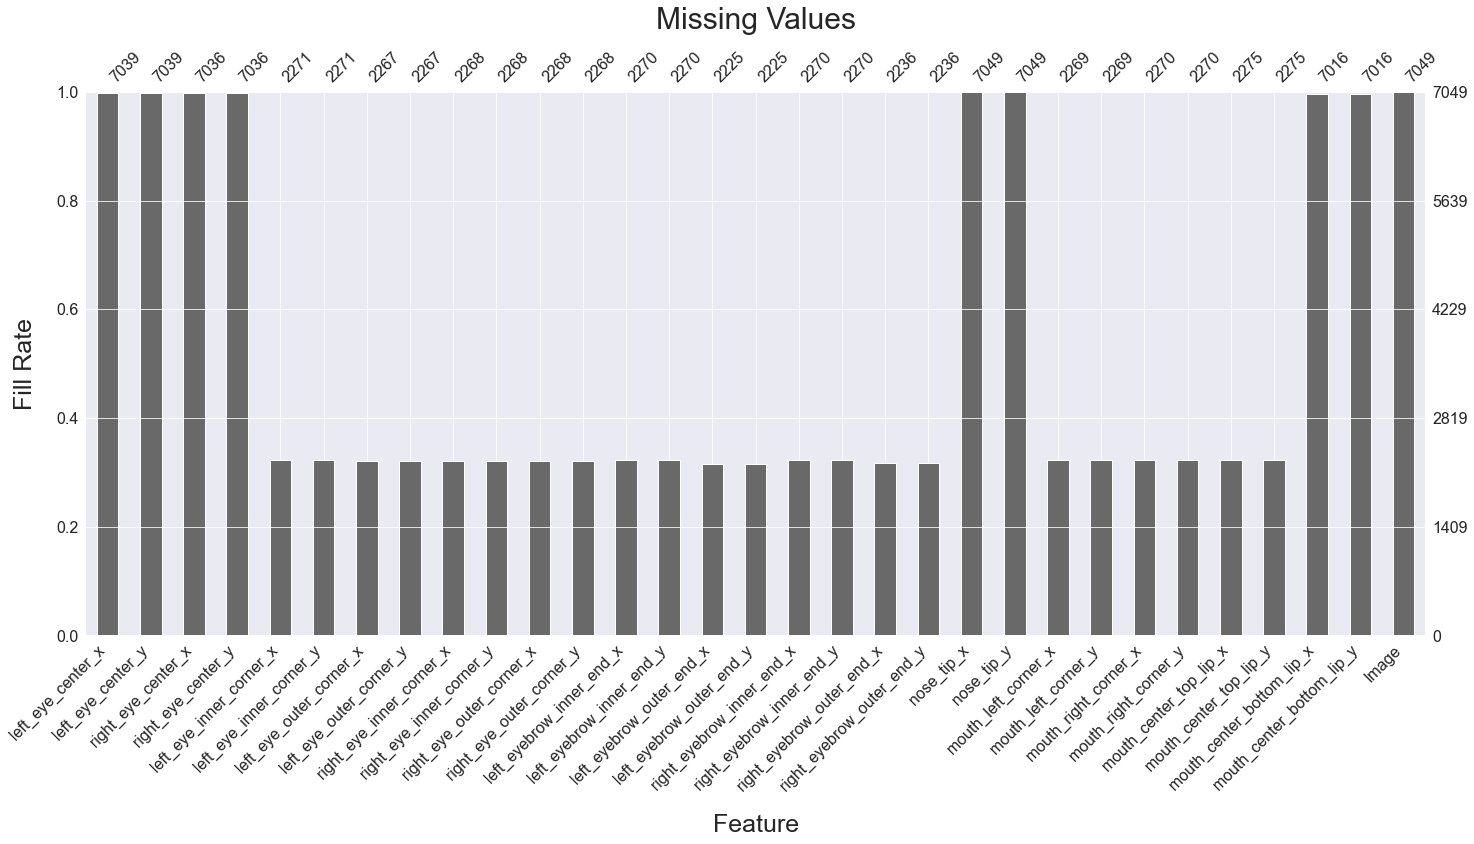

In [97]:
# view missing values
import missingno as msno
fig, ax = plt.subplots()
msno.bar(train)
ax.set_title("Missing Values", fontsize = 30, pad = 20)
ax.set_xlabel("Feature", fontsize = 25, labelpad = 20)
ax.set_ylabel("Fill Rate", fontsize = 25, labelpad = 20)
plt.show()

The main challenge presented by our dataset is the abundance of NULL values. In particular, only a small number of our objective variables do not have missing values. Aside from a few key points (center of each eye, tip of the nose, and center of the mouth) a significant majority of the data is missing key labels. In fact, over 67% of the data are missing the necessary labels.

In [98]:
# EDA see percentage of na's for each column in the training dataset
train.isna().sum()/len(train)*100

left_eye_center_x             0.141864
left_eye_center_y             0.141864
right_eye_center_x            0.184423
right_eye_center_y            0.184423
left_eye_inner_corner_x      67.782664
left_eye_inner_corner_y      67.782664
left_eye_outer_corner_x      67.839410
left_eye_outer_corner_y      67.839410
right_eye_inner_corner_x     67.825223
right_eye_inner_corner_y     67.825223
right_eye_outer_corner_x     67.825223
right_eye_outer_corner_y     67.825223
left_eyebrow_inner_end_x     67.796851
left_eyebrow_inner_end_y     67.796851
left_eyebrow_outer_end_x     68.435239
left_eyebrow_outer_end_y     68.435239
right_eyebrow_inner_end_x    67.796851
right_eyebrow_inner_end_y    67.796851
right_eyebrow_outer_end_x    68.279189
right_eyebrow_outer_end_y    68.279189
nose_tip_x                    0.000000
nose_tip_y                    0.000000
mouth_left_corner_x          67.811037
mouth_left_corner_y          67.811037
mouth_right_corner_x         67.796851
mouth_right_corner_y     

There are a lot of null values in the data, and we will need to fill them in or simply use the only fully labeled data.
This will reduce the amount of data we have to work with, but hopefully will increase the accuracy of our model.

Continuing with our EDA, we will take a look at the distribution of the labels in the data.

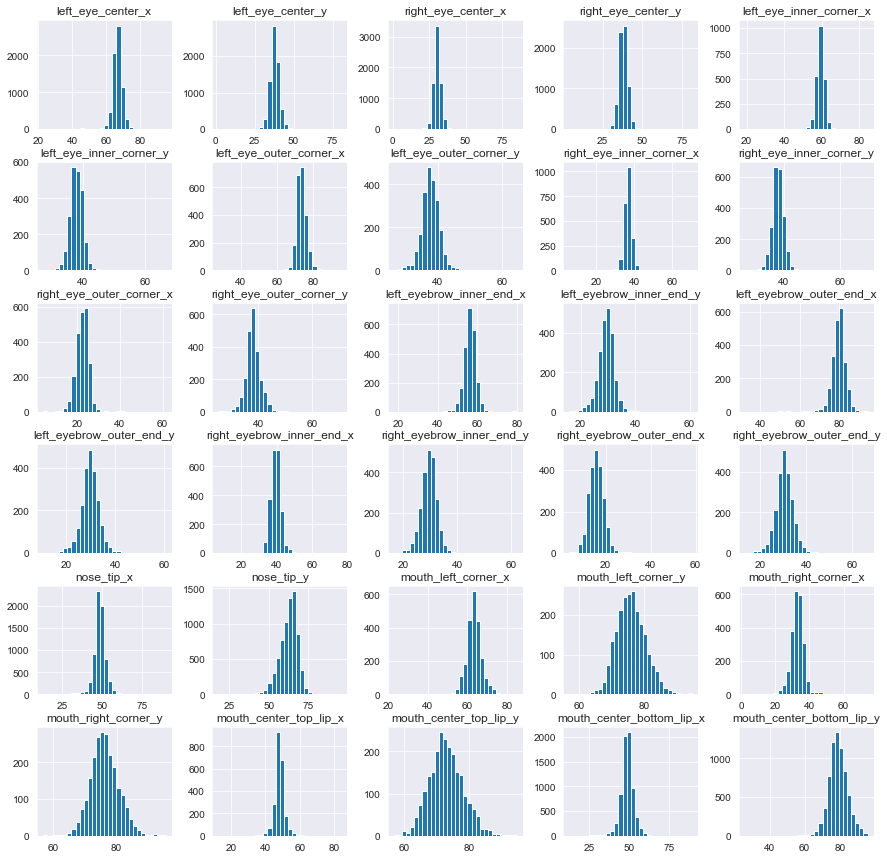

In [99]:
#continue EDA, see distribution of all coordinates in train data except the "Image" column
train.hist(bins = 30, figsize=(15,15))
plt.show()

## Addressing Missing Values
The amount of NULL values will make prediction accuracy very low. We choose to address the missing data issue with the following strategies:

- We will drop all missing values (we lose 70% of the dataset when removing NAs)
- We will also create a dataset with imputing the labels with forward fill. This will provide us with more available training data, but the imputed values will likely provide less accurate labels, which may harm our modeling moving forward. 

In [100]:
#drop NAs from train and split into training and dev
train_noNA_temp = train.dropna()
dev_set = train_noNA_temp[:500]
train_noNA = train_noNA_temp[500:]

#From the complete train set, drop the rows which will be included in the dev set
cond = train['Image'].isin(dev_set['Image'])
train.drop(train[cond].index, inplace = True)

#Create a ffill set based off the training data 
train_ffill = train.fillna(method='ffill')

def load_images(image_data):
    images = []
    for idx, sample in image_data.iterrows():
        image = np.array(sample['Image'].split(' '), dtype=int)
        image = np.reshape(image, (96,96,1))
        images.append(image)
    images = np.array(images)/255.
    return images

def load_labels(label_data):
    label_data = label_data.drop(['Image'], axis=1)
    label_features = []
    for idx, features in label_data.iterrows():
        label_features.append(features)
    label_features = np.array(label_features, dtype=float)
    return label_features


#Set of full data with ffill for missing labels
train_data_ffill  = load_images(train_ffill)
train_labels_ffill = load_labels(train_ffill)


#Dataset with only no NA rows
train_data_noNA  = load_images(train_noNA)
train_labels_noNA = load_labels(train_noNA)


#Dev set for testing 
dev_data = load_images(dev_set)
dev_labels = load_labels(dev_set)


#Test images for Kaggle competition 
test_images = load_images(test)


In [101]:
#Confirm size of the datasets
print('Number of records:', train_data.shape[0])
print('Number of records with no NULLS:', train_data_noNA.shape[0])

Number of records: 5000
Number of records with no NULLS: 1640


## Viusalizing the Images and Facial Keypoints

To get a better sense of our data, we will visualize the available data to see how the examples with missing values appear, those with all labels available, as well as the forward filled imputed examples.

In [102]:
def show_images(data, labels, num_examples=3, random=False):

    #transform data  into 2D matrix
    X2D = np.reshape(data, (-1, 96, 96))

    num = num_examples * 3
    count = 0

    #create a figure
    fig, axes = plt.subplots(num_examples, 3, figsize = (9.6, 9.6))
    
    if random:
        #iterate across the row of images and display one image in each of the num_examples boxes
        for n in range(num):
            ax = axes[count//num_examples, count%num_examples]
            rand = randrange(0, len(data))
            ax.imshow(X2D[rand], cmap = 'gray')
            count += 1
            for loc in range(0, len(labels[n]), 2):
                ax.plot(labels[rand][loc], labels[rand][loc+1], '*r')
    
    else:
        #iterate across the row of images and display one image in each of the num_examples boxes
        for n in range(num):
          ax = axes[count//num_examples, count%num_examples]
          ax.imshow(X2D[n], cmap = 'gray')
          count += 1
          for loc in range(0, len(labels[n]), 2):
              ax.plot(labels[n][loc], labels[n][loc+1], '*r')

    plt.tight_layout()
    plt.show()

### Example Images without all labeled points.

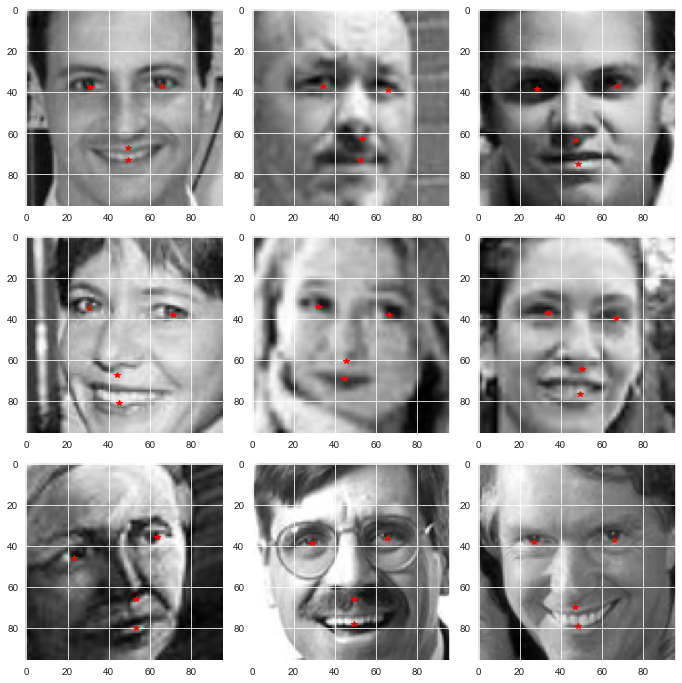

In [103]:
#explore some of the images in the training data
show_images(train_data, train_labels, random= True)

These images show the facial keypoints of the person, with some images being completely labeled, and some images with missing points.

### View images with all labels.

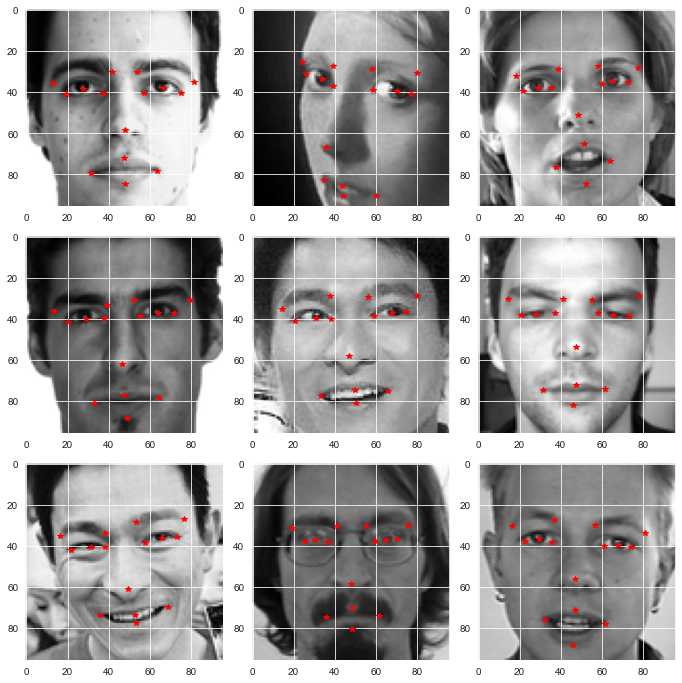

In [104]:
#Same analysis as above but with the noNA dataset - notice the how all the features are marked on the face
show_images(train_data_noNA, train_labels_noNA, random= True)

The examples for the fully labeled data appear to not only have the benefit of being complete, they also seem to have each of the labeled keypoints accurately positioned. Before we attempt to impute missing values for the incomplete labeled data, we believe that the no-Null dataset is the richest and will provide the most value to our future models. 

### View images with forward filled points.

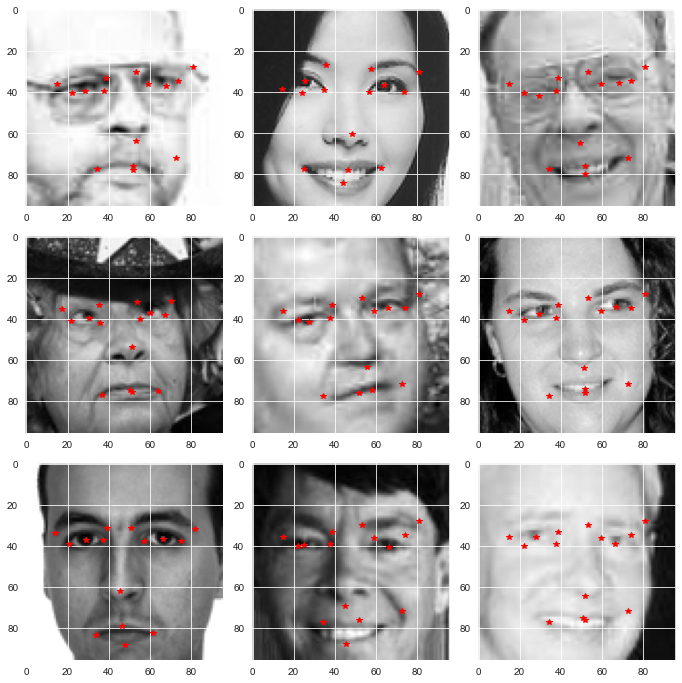

In [105]:
show_images(train_data_ffill, train_labels_ffill, random= True)

while many of the ffill labels are close to the correct location, there is still a bit of discrepancy.

In [106]:
#Confirm size of the datasets
print(train_data_noNA.shape)
print(train_labels_noNA.shape)
print(train_data_ffill.shape)
print(train_labels_ffill.shape)
print(dev_data.shape)
print(dev_labels.shape)

(1640, 96, 96, 1)
(1640, 30)
(6549, 96, 96, 1)
(6549, 30)
(500, 96, 96, 1)
(500, 30)


## Augmenting the Data

As shown above, excluding records with missing data from our dateset drastically reduces our sample size. We can perform image transformations on our complete records to partially account for the reduction in sample size. Doing so will make our predictions more generalizable. We will augment our existing examples using transformations such as rotation, altering the brightness, shifting the images, adding noise, or blurring the images.

In [107]:
# define image augmentation functions
def rotate_augmentation(images, keypoints, angles):
    rotated_images = []
    rotated_keypoints = []
    for angle in angles:    # Rotation augmentation for a list of angle values
        for angle in [angle,-angle]:
            rotation_matrix = cv2.getRotationMatrix2D((48,48), angle, 1.0)
            angle_rad = -angle*pi/180.     # Obtain angle in radians from angle in degrees (notice negative sign for change in clockwise vs anti-clockwise directions from conventional rotation to cv2's image rotation)
            # rotate images
            for image in images:
                rotated_image = cv2.warpAffine(image, rotation_matrix, (96,96), flags=cv2.INTER_CUBIC)
                rotated_images.append(rotated_image)
            rotated_images_reshaped = np.reshape(rotated_images, (-1,96,96,1))
            # rotate keypoints
            for keypoint in keypoints:
                rotated_keypoint = keypoint - 48.    # Subtract the middle value of the image dimension
                for idx in range(0, len(rotated_keypoint), 2):
                    # https://in.mathworks.com/matlabcentral/answers/93554-how-can-i-rotate-a-set-of-points-in-a-plane-by-a-certain-angle-about-an-arbitrary-point
                    rotated_keypoint[idx] = rotated_keypoint[idx]*cos(angle_rad)-rotated_keypoint[idx+1]*sin(angle_rad)
                    rotated_keypoint[idx+1] = rotated_keypoint[idx]*sin(angle_rad)+rotated_keypoint[idx+1]*cos(angle_rad)
                rotated_keypoint += 48.   # Add the earlier subtracted value
                rotated_keypoints.append(rotated_keypoint)
            rotated_keypoints_reshaped = np.reshape(rotated_keypoints, (-1, 30))
    return rotated_images_reshaped, rotated_keypoints_reshaped

def alter_brightness(images, keypoints, increase_factor=1.2, decrease_factor=0.6):
    altered_brightness_images = []
    inc_brightness_images = np.clip(images*increase_factor, 0.0, 1.0)    # Increased brightness & clip any values outside the range of [-1,1]
    dec_brightness_images = np.clip(images*decrease_factor, 0.0, 1.0)    # Decreased brightness & clip any values outside the range of [-1,1]
    altered_brightness_images.extend(inc_brightness_images)
    altered_brightness_images.extend(dec_brightness_images)
    altered_brightness_images_reshaped = np.reshape(altered_brightness_images, (-1,96,96,1))
    altered_brightness_keypoints_reshaped = np.reshape(np.concatenate((keypoints, keypoints)), (-1, 30))
    return altered_brightness_images_reshaped, altered_brightness_keypoints_reshaped

def shift_images(images, keypoints, pixel_shifts):
    shifted_images = []
    shifted_keypoints = []
    for shift in pixel_shifts:    # Augmenting over several pixel shift values
        for (shift_x,shift_y) in [(-shift,-shift),(-shift,shift),(shift,-shift),(shift,shift)]:
            shift_matrix = np.float32([[1,0,shift_x],[0,1,shift_y]])
            for image, keypoint in zip(images, keypoints):
                shifted_image = cv2.warpAffine(image, shift_matrix, (96,96), flags=cv2.INTER_CUBIC)
                shifted_keypoint = np.array([(point+shift_x) if idx%2==0 else (point+shift_y) for idx, point in enumerate(keypoint)])
                if np.all(0.0<shifted_keypoint) and np.all(shifted_keypoint<96.0):
                    shifted_images.append(shifted_image.reshape(96,96,1))
                    shifted_keypoints.append(shifted_keypoint)
    shifted_images_reshaped = np.reshape(shifted_images, (-1,96,96,1))
    shifted_keypoints = np.clip(shifted_keypoints,0.0,96.0)
    shifted_keypoints_reshaped = np.reshape(shifted_keypoints, (-1, 30))
    return shifted_images_reshaped, shifted_keypoints_reshaped

def add_random_noise(images, keypoints, noise_factor=0.008):
    noisy_images = []
    for image in images:
        noisy_image = cv2.add(image, noise_factor*np.random.randn(96,96,1))    # Adding random normal noise to the input image & clip the resulting noisy image between [-1,1]
        noisy_images.append(noisy_image.reshape(96,96,1))
    noisy_images_reshaped = np.reshape(noisy_images, (-1,96,96,1))
    return noisy_images_reshaped, keypoints

def guassian_blur(images, keypoints, kernel=(5,5)):
    blurred_images = []
    for image in images:
        dst = cv2.GaussianBlur(image, kernel, cv2.BORDER_DEFAULT)
        blurred_image = dst.reshape(96,96,1)
        blurred_images.append(blurred_image)
    blurred_images_reshaped = np.reshape(blurred_images, (-1,96,96,1))
    return blurred_images_reshaped, keypoints

### Original Images

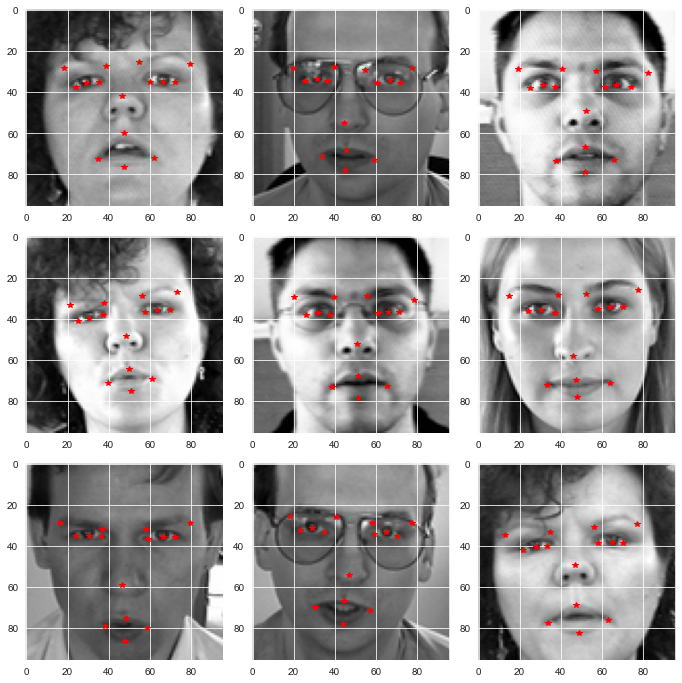

In [108]:
show_images(train_data_noNA, train_labels_noNA, random=False)

### Rotated Images

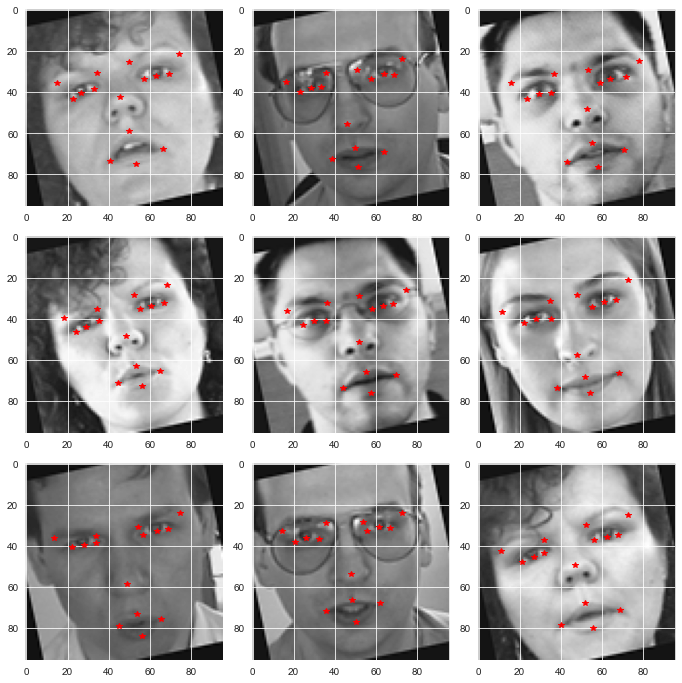

In [109]:
# rotate images and keypoints
train_data_rotated, train_labels_rotated = rotate_augmentation(train_data_noNA, train_labels_noNA, [12])
show_images(train_data_rotated, train_labels_rotated, random=False)

### Enhanced Brightness of Images

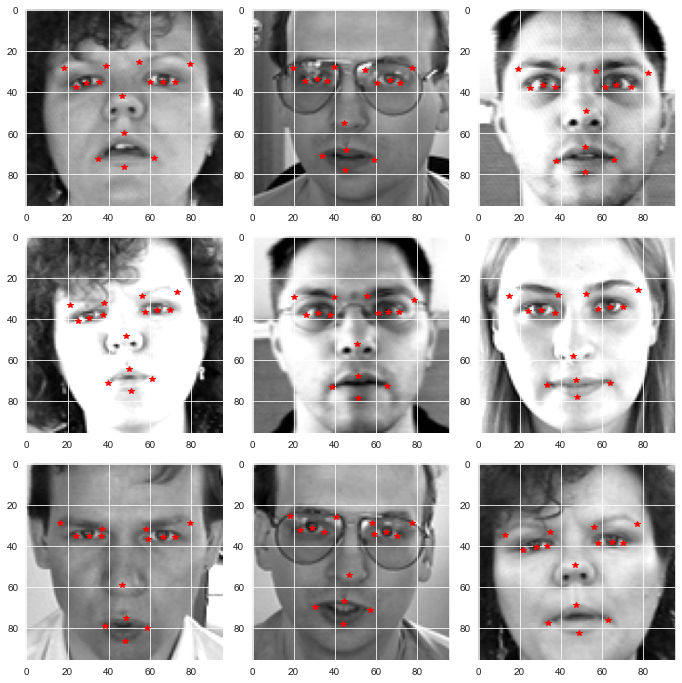

In [110]:
# alter brightness
train_data_brightness, train_labels_brightness = alter_brightness(
                                                        train_data_noNA,
                                                        train_labels_noNA,
                                                        increase_factor=1.3,
                                                        decrease_factor=0.6
                                                    )
show_images(train_data_brightness, train_labels_brightness)

### Shift Images

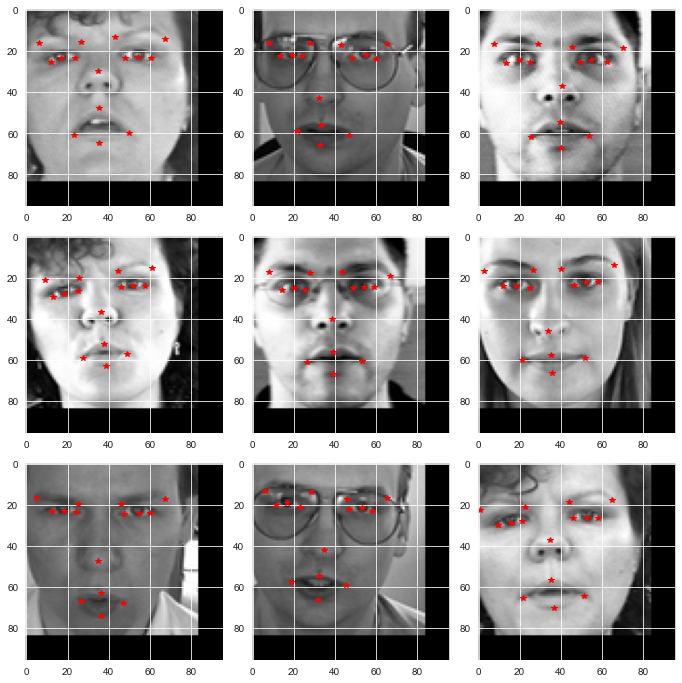

In [111]:
# shift images and keypoints
train_data_shifted, train_labels_shifted = shift_images(train_data_noNA, train_labels_noNA, [12])
show_images(train_data_shifted, train_labels_shifted)

### Add Noise to Images

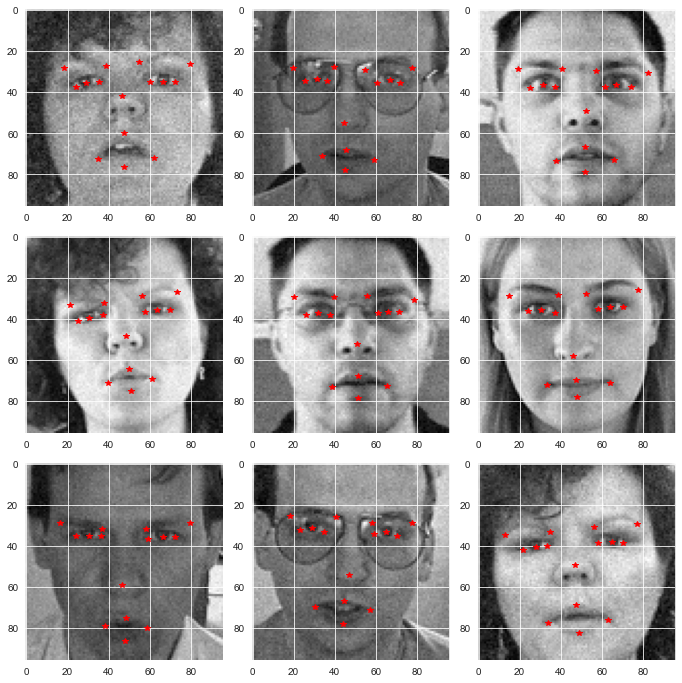

In [112]:
# add random noise
train_data_noise, train_labels_noise = add_random_noise(train_data_noNA, train_labels_noNA, 0.03)
show_images(train_data_noise, train_labels_noise)

### Add Gaussian Blur to Images

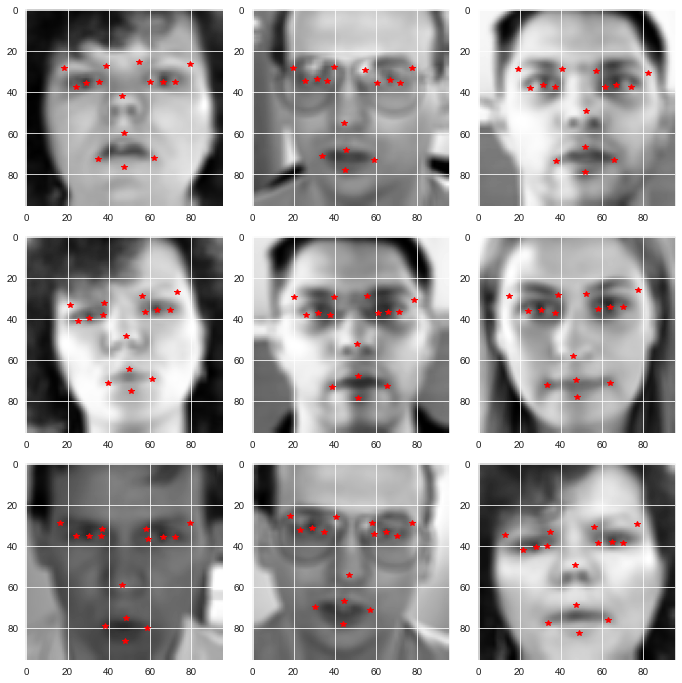

In [113]:
# apply gaussian blur
train_data_blurred, train_labels_blurred = guassian_blur(train_data_noNA, train_labels_noNA, kernel=(5,5))
show_images(train_data_blurred, train_labels_blurred)

In [114]:
# merge all augmented data
train_data_aug = np.concatenate(
    (train_data_noNA, train_data_rotated, train_data_shifted, train_data_brightness, train_data_noise, train_data_blurred)
)

train_labels_aug = np.concatenate(
    (train_labels_noNA, train_labels_rotated, train_labels_shifted, train_labels_brightness, train_labels_noise, train_labels_blurred)
)

print('Augmented Dataset Number of Records:', train_data_aug.shape[0])

Augmented Dataset Number of Records: 16267


Our training dataset increased by about 10x after adding the augmented data. Additionally, these augmented images will help against overfitting.

### Augmentation of FFill Label Data

Similarly, we augment data on the forward fill dataset

In [115]:
# rotate images and keypoints
train_data_ffill_rotated, train_labels_ffill_rotated = rotate_augmentation(train_data_ffill, train_labels_ffill, [12])

# alter brightness
train_data_ffill_brightness, train_labels_ffill_brightness = alter_brightness(
                                                        train_data_ffill,
                                                        train_labels_ffill,
                                                        increase_factor=1.2,
                                                        decrease_factor=0.6
                                                    )

# shift images and keypoints
train_data_ffill_shifted, train_labels_ffill_shifted = shift_images(train_data_ffill, train_labels_ffill, [12])

# add random noise
train_data_ffill_noise, train_labels_ffill_noise = add_random_noise(train_data_ffill, train_labels_ffill, 0.03)

# apply gaussian blur
train_data_ffill_blurred, train_labels_ffill_blurred = guassian_blur(train_data_ffill, train_labels_ffill, kernel=(5,5))

# merge all augmented data
train_data_ffill_aug = np.concatenate(
    (train_data_ffill, train_data_ffill_rotated, train_data_ffill_shifted, train_data_ffill_brightness, train_data_ffill_noise, train_data_ffill_blurred)
)

train_labels_ffill_aug = np.concatenate(
    (train_labels_ffill, train_labels_ffill_rotated, train_labels_ffill_shifted, train_labels_ffill_brightness, train_labels_ffill_noise, train_labels_ffill_blurred)
)

# Modeling on the data

In [22]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlyStopping = EarlyStopping(monitor='loss', patience=30, mode='min',
                             baseline=None)

rlp = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, min_lr=1e-15, mode='min', verbose=1)

In [23]:
# shape tuples for reshaping the data for model
train_reshape = (5000, 9216)
train_noNA_reshape = (1640, 9216)
dev_reshape = (2049, 9216)
dev_noNA_reshape = (500, 9216)
label_reshape= (-1, 30)
dev_data_baseline_reshape = (588, 9216)

In [ ]:
dev_data_baseline, dev_labels_baseline = X[5000:], Y[5000:]
label_index = pd.DataFrame(dev_labels_baseline).dropna().index
dev_labels_baseline = pd.DataFrame(dev_labels_baseline).dropna()
dev_data_baseline = dev_data_baseline[label_index,:]

In [24]:
#function to pickle the models
def pickle_stuff(model, time, history, model_type, folder = 'models/'):
    model_name = folder + model_type
    with open(model_name, 'wb') as f:
        pickle.dump(model, f)
        pickle.dump(time, f)
        pickle.dump(history, f)

#function to unpickle the models
def unpickle_stuff(model_type, folder = 'models/'):
    with open(folder + model_type, 'rb') as f:
        model = pickle.load(f)
        time = pickle.load(f)
        history = pickle.load(f)
    return model, time, history

### Baseline
- creating a perceptron model with a two hidden layers

In [25]:
# Baseline model
model_base = Sequential()
model_base.add(Dense(units=30, input_dim = 9216, activation='sigmoid'))
model_base.add(Dense(units=30, input_dim = 30, activation='softmax'))

sgd = optimizers.SGD(learning_rate=0.01)
model_base.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

start_time_base = time.time()
history_base = model_base.fit(train_data.reshape(train_reshape), train_labels, shuffle=True, batch_size=1, verbose=0, epochs=20)
train_time_base = time.time() - start_time_base

#pickle
pickle_stuff(model_base, train_time_base, history_base, 'baseline_model')

# #unpickle stuff
# model_base, train_time_base, history_base = unpickle_stuff('baseline_model')

print ('Train time = ', train_time_base)
score_base = model_base.evaluate(dev_data_baseline.reshape(dev_data_baseline_reshape), dev_labels_baseline, verbose=0) 
print('Test score:', score_base[0]) 
print('Test accuracy:', score_base[1])

In [ ]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_base.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

### Baseline model but with only the noNA dataset

In [123]:
# No NA model
model_NN_noNA1 = Sequential()
model_NN_noNA1.add(Dense(units=30, input_dim=9216, activation='softmax'))

sgd = optimizers.SGD(learning_rate=0.01)
model_NN_noNA1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

start_time_noNA1 = time.time()
history_NN_noNA1 = model_NN_noNA1.fit(train_data_noNA.reshape(train_noNA_reshape), train_labels_noNA, shuffle=False, batch_size=1, verbose=0, epochs=10) 
train_time_noNA1 = time.time() - start_time_noNA1

#pickle
pickle_stuff(model_NN_noNA1, train_time_noNA1, history_NN_noNA1, 'NN_noNA1')

# #unpickle stuff
# model_NN_noNA1, train_time_noNA1, history_NN_noNA1 = unpickle_stuff('NN_noNA1')


score_NN_noNA1 = model_NN_noNA1.evaluate(dev_data.reshape(dev_noNA_reshape), dev_labels, verbose=0) 
print('Test score:', score_NN_noNA1[0]) 
print('Test accuracy:', score_NN_noNA1[1])

Test score: 12976111616.0
Test accuracy: 0.8300000429153442


In [ ]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_NN_noNA1.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

### Convolutional Model Baseline Attempt (FFILL)

In [27]:
# #build archetecture
# model_CNN_ffill1 = Sequential() 
# model_CNN_ffill1.add(Conv2D(64, kernel_size=(3, 3),activation='relu',input_shape=(96, 96, 1)))
# model_CNN_ffill1.add(MaxPooling2D(pool_size=(2, 2)))
# model_CNN_ffill1.add(Dropout(0.5))
# model_CNN_ffill1.add(Flatten())
# model_CNN_ffill1.add(Dense(96))
# model_CNN_ffill1.add(BatchNormalization())
# model_CNN_ffill1.add(Activation('relu'))
# model_CNN_ffill1.add(Dense(30))

# model_CNN_ffill1.summary()
# model_CNN_ffill1.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# #Train the model
# start_time_CNN_ffill1 = time.time()
# history_CNN_ffill1 = model_CNN_ffill1.fit(train_data_ffill, train_labels_ffill, batch_size=64, epochs=100, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
# train_time_CNN_ffill1 = time.time() - start_time_CNN_ffill1


# #pickle 
# pickle_stuff(model_CNN_ffill1, train_time_CNN_ffill1, history_CNN_ffill1, 'CNN_ffill1')

#unpickle
model_CNN_ffill1, train_time_CNN_ffill1, history_CNN_ffill1 = unpickle_stuff('CNN_ffill1')


#Score the model
score_CNN_ffill1 = model_CNN_ffill1.evaluate(dev_data, dev_labels, verbose=0)
print('Test score:', score_CNN_ffill1[0]) 
print('Test accuracy:', score_CNN_ffill1[1])



Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Test score: nan
Test accuracy: 0.16600000858306885


Text(0.5, 0.98, 'Model Metrics')

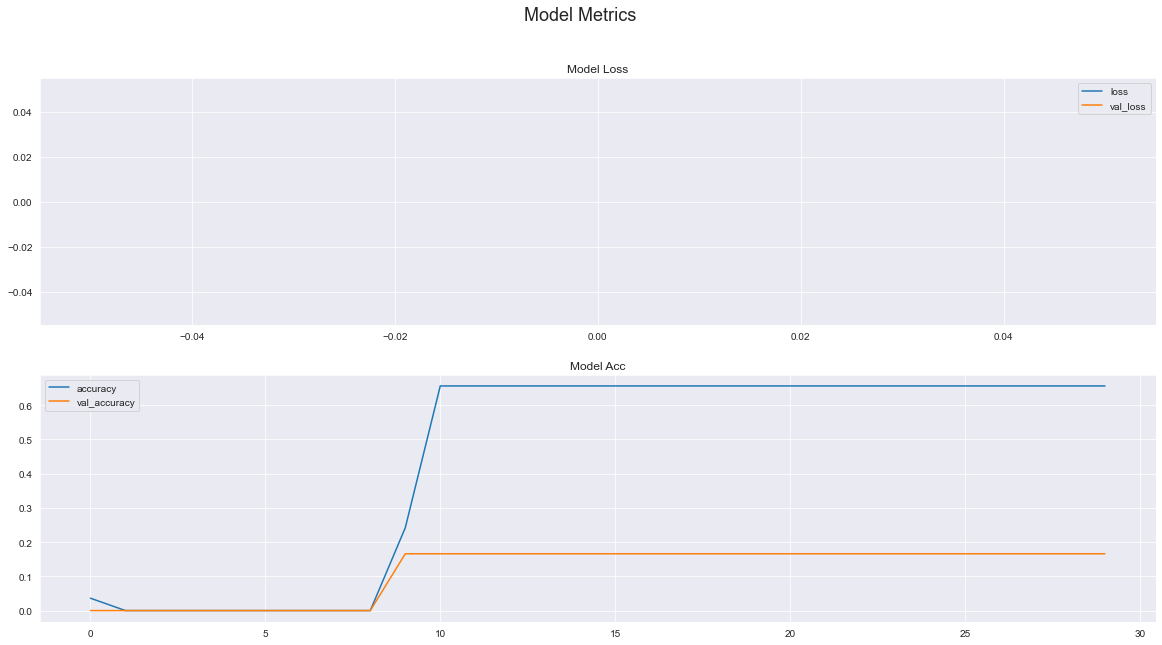

In [28]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_CNN_ffill1.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

### Same CNN as before, but training with the noNA dataset
- in using the noNA dataset, we can train the model with a much smaller dataset, but much more accurate labels. We expect this to lead to a higher validation accuracy.

In [29]:
# #Build Model Architecture
# model_CNN_noNA1 = Sequential() 
# model_CNN_noNA1.add(Conv2D(64, kernel_size=(3, 3),activation='relu',input_shape=(96, 96, 1)))
# model_CNN_noNA1.add(MaxPooling2D(pool_size=(2, 2)))
# model_CNN_noNA1.add(Dropout(0.2))
# model_CNN_noNA1.add(Flatten())
# model_CNN_noNA1.add(Dense(96))
# model_CNN_noNA1.add(BatchNormalization())
# model_CNN_noNA1.add(Activation('relu'))
# model_CNN_noNA1.add(Dense(30))

# model_CNN_noNA1.summary()
# model_CNN_noNA1.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])


# #Train Model
# start_time_CNN_noNA1 = time.time()
# history_CNN_noNA1 = model_CNN_noNA1.fit(train_data_noNA, train_labels_noNA, batch_size=64, epochs=100, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
# train_time_CNN_noNA1 = time.time() - start_time_CNN_noNA1

# #Pickle
# pickle_stuff(model_CNN_noNA1, train_time_CNN_noNA1, history_CNN_noNA1, 'model_CNN_noNA1')

#unpickle
model_CNN_noNA1, train_time_CNN_noNA1, history_CNN_noNA1 = unpickle_stuff('model_CNN_noNA1')


#evaluate the model
score_CNN_noNA1 = model_CNN_noNA1.evaluate(dev_data, dev_labels)
print('Test score:', score_CNN_noNA1[0]) 
print('Test accuracy:', score_CNN_noNA1[1])


16/16 [==============================] - 2s 135ms/step - loss: 13.1649 - accuracy: 0.8280
Test score: 13.164901733398438
Test accuracy: 0.8280000686645508


Text(0.5, 0.98, 'Model Metrics')

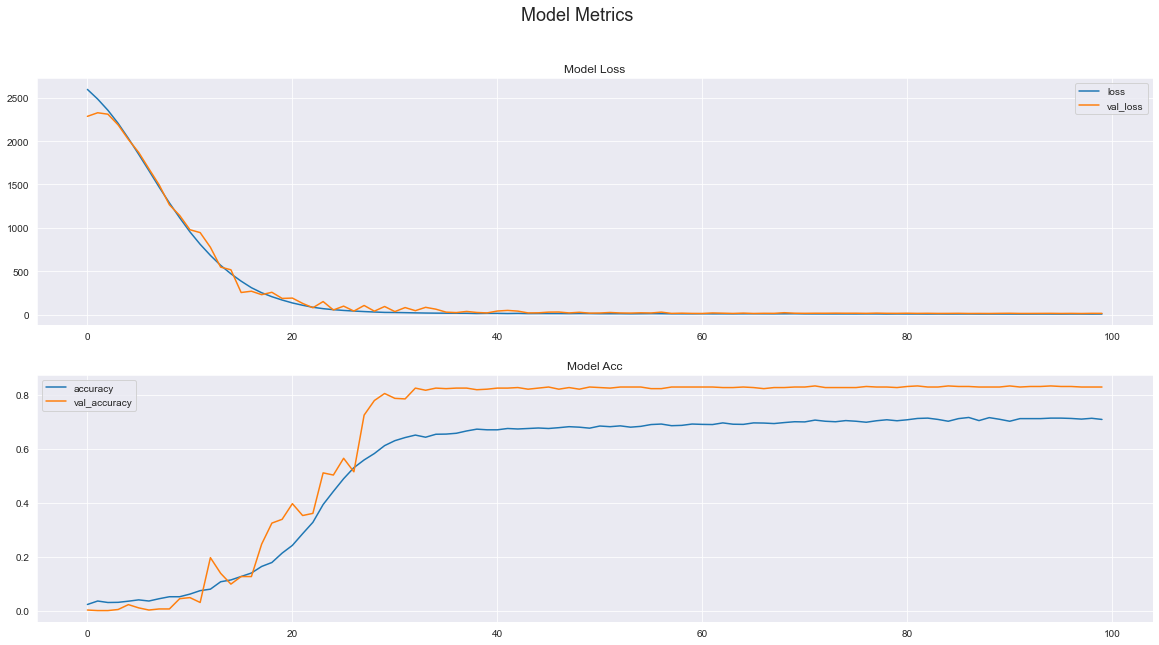

In [30]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_CNN_noNA1.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

The model metrics with the noNA dataset are much better than previous models. We will primarily use this dataset throughout the next models.

### Transfer learning with Resnet50: CNN with Pre-trained Resnet and one dense layer

There are a lot of pre-trained models that are included in the tensorflow package. Resnet50 is a popular model that has been trained on imagenet data and has been used on a wide range of machine learning tasks with transfer learning. We will use this model to train our own model.

In [80]:
model_resnet_noNA_D1 = Sequential() 
pretrained_model = ResNet50(input_shape=(96,96,3), include_top=False, weights='imagenet')
pretrained_model.trainable = True

#Build Model
model_resnet_noNA_D1.add(Conv2D(3, kernel_size=(1, 1), activation='relu', padding= 'same' ,input_shape=(96, 96, 1)))
model_resnet_noNA_D1.add(LeakyReLU(alpha=0.1))
model_resnet_noNA_D1.add(pretrained_model)
model_resnet_noNA_D1.add(MaxPooling2D(pool_size=(2, 2)))
model_resnet_noNA_D1.add(Dropout(0.1))
model_resnet_noNA_D1.add(Flatten())
model_resnet_noNA_D1.add(Dense(30))
model_resnet_noNA_D1.summary()

model_resnet_noNA_D1.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 3)         6         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 96, 96, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 2048)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1, 1, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                        

In [81]:
# #Train Model 
# start_time_resnet_noNA_D1 = time.time()
# history_resnet_noNA_D1 = model_resnet_noNA_D1.fit(train_data_noNA, train_labels_noNA, batch_size=64, epochs=100, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
# train_time_resnet_noNA_D1 = time.time() - start_time_resnet_noNA_D1

# #pickle
# pickle_stuff(model_resnet_noNA_D1, train_time_resnet_noNA_D1, history_resnet_noNA_D1, 'model_resnet_noNA_D1')

#unpickle
model_resnet_noNA_D1, train_time_resnet_noNA_D1, history_resnet_noNA_D1 = unpickle_stuff('model_resnet_noNA_D1')

score_resnet_noNA_D1 = model_resnet_noNA_D1.evaluate(dev_data, dev_labels)
print('Test score:', score_resnet_noNA_D1[0]) 
print('Test accuracy:', score_resnet_noNA_D1[1])


Epoch 1/100
26/26 [==============================] - 14s 342ms/step - loss: 262.9612 - accuracy: 0.4994 - val_loss: 6528.2866 - val_accuracy: 0.0020 - lr: 0.0010
Epoch 2/100
26/26 [==============================] - 7s 252ms/step - loss: 10.8704 - accuracy: 0.6433 - val_loss: 90.6571 - val_accuracy: 0.0020 - lr: 0.0010
Epoch 3/100
26/26 [==============================] - 7s 252ms/step - loss: 8.3702 - accuracy: 0.6598 - val_loss: 289.8393 - val_accuracy: 0.0020 - lr: 0.0010
Epoch 4/100
26/26 [==============================] - 7s 253ms/step - loss: 6.6832 - accuracy: 0.6829 - val_loss: 295.1180 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/100
26/26 [==============================] - 7s 255ms/step - loss: 5.8944 - accuracy: 0.6750 - val_loss: 220.6030 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 6/100
26/26 [==============================] - 7s 251ms/step - loss: 6.3894 - accuracy: 0.7091 - val_loss: 143.5883 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 7/100
26/26 [=========================

Text(0.5, 0.98, 'Model Metrics')

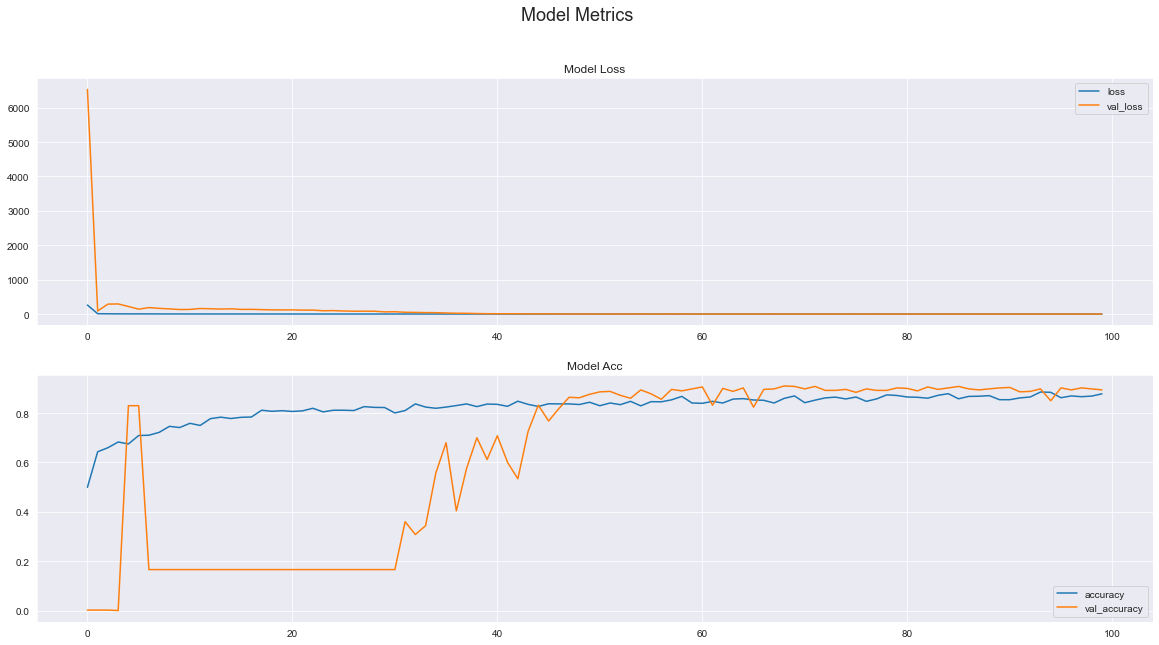

In [82]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_resnet_noNA_D1.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

We improved our accuracy and loss with this simple transfer learning Resnet model. Let's try and expand the fully connected Dense layers to see if we can improve our accuracy.

### Resnet pretrained with two dense layers

In [34]:
# #Build resnet model
# model_resnet_noNA_D2 = Sequential() 
# pretrained_model = ResNet50(input_shape=(96,96,3), include_top=False, weights='imagenet')
# pretrained_model.trainable = True

# #Build Model Architecture
# model_resnet_noNA_D2.add(Conv2D(3, kernel_size=(1, 1), activation='relu', padding= 'same' ,input_shape=(96, 96, 1)))
# model_resnet_noNA_D2.add(LeakyReLU(alpha=0.1))
# model_resnet_noNA_D2.add(pretrained_model)
# model_resnet_noNA_D2.add(MaxPooling2D(pool_size=(2, 2)))
# model_resnet_noNA_D2.add(Dropout(0.1))
# model_resnet_noNA_D2.add(Flatten())
# model_resnet_noNA_D2.add(Dense(96))
# model_resnet_noNA_D2.add(Dense(30))

# model_resnet_noNA_D2.summary()

# model_resnet_noNA_D2.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])


In [35]:
# #Train Model
# start_time_resnet_noNA_D2 = time.time()
# history_resnet_noNA_D2 = model_resnet_noNA_D2.fit(train_data_noNA, train_labels_noNA, batch_size=64, epochs=100, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
# train_time_resnet_noNA_D2 = time.time() - start_time_resnet_noNA_D2

# #pickle
# pickle_stuff(model_resnet_noNA_D2, train_time_resnet_noNA_D2, history_resnet_noNA_D2, 'model_resnet_noNA_D2')

#unpickle
model_resnet_noNA_D2, train_time_resnet_noNA_D2, history_resnet_noNA_D2 = unpickle_stuff('model_resnet_noNA_D2')

#Evaluate Model
score_resnet_noNA_D2 = model_resnet_noNA_D2.evaluate(dev_data, dev_labels)
print('Test score:', score_resnet_noNA_D2[0]) 
print('Test accuracy:', score_resnet_noNA_D2[1])

16/16 [==============================] - 1s 46ms/step - loss: 0.8175 - accuracy: 0.9000
Test score: 0.8175055384635925
Test accuracy: 0.9000000357627869


Text(0.5, 0.98, 'Model Metrics')

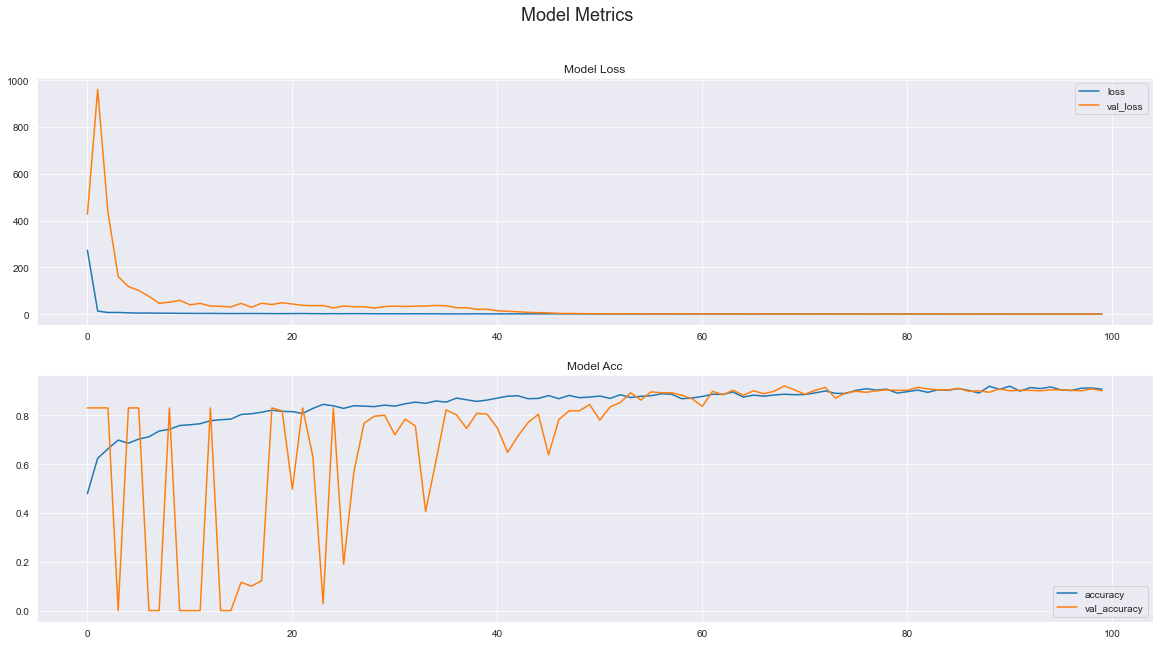

In [36]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_resnet_noNA_D2.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

Again, accuracy and loss are improved, although at a much smaller incriment than the previous model. Let's try and see if adding even more dense layers will improve our accuracy.

### ResnetV2 With lots of Dense Layers


In [37]:
# #Build resnet model
# model_resnet_noNA_C1D4 = Sequential() 
# pretrained_model = ResNet50V2(input_shape=(96,96,3), include_top=False, weights='imagenet')
# pretrained_model.trainable = True

# #Build Model Architecture
# model_resnet_noNA_C1D4.add(Conv2D(64, kernel_size=(2, 2), activation='relu', padding= 'same' ,input_shape=(96, 96, 1)))
# model_resnet_noNA_C1D4.add(LeakyReLU(alpha=0.2))
# model_resnet_noNA_C1D4.add(Conv2D(3, kernel_size=(1, 1), activation='relu', padding= 'same' ,input_shape=(96, 96, 64)))
# model_resnet_noNA_C1D4.add(LeakyReLU(alpha=0.1))
# model_resnet_noNA_C1D4.add(pretrained_model)
# model_resnet_noNA_C1D4.add(MaxPooling2D(pool_size=(2, 2)))
# model_resnet_noNA_C1D4.add(Dropout(0.1))
# model_resnet_noNA_C1D4.add(Flatten())
# model_resnet_noNA_C1D4.add(Dense(1024))
# model_resnet_noNA_C1D4.add(Dense(512))
# model_resnet_noNA_C1D4.add(Dense(96))
# model_resnet_noNA_C1D4.add(Dense(30))


# model_resnet_noNA_C1D4.summary()

# model_resnet_noNA_C1D4.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [120]:
# #Train Model
# start_time_resnet_noNA_C1D4 = time.time()
# history_resnet_noNA_C1D4 = model_resnet_noNA_C1D4.fit(train_data_noNA, train_labels_noNA, batch_size=64, epochs=100, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
# train_time_resnet_noNA_C1D4 = time.time() - start_time_resnet_noNA_C1D4

# #pickle
# pickle_stuff(model_resnet_noNA_C1D4, train_time_resnet_noNA_C1D4, history_resnet_noNA_C1D4, 'model_resnet_noNA_C1D4')

#unpickle
model_resnet_noNA_C1D4, train_time_resnet_noNA_C1D4, history_resnet_noNA_C1D4 = unpickle_stuff('model_resnet_noNA_C1D4')

score_resnet_noNA_C1D4 = model_resnet_noNA_C1D4.evaluate(dev_data, dev_labels)
print('Test score:', score_resnet_noNA_C1D4[0]) 
print('Test accuracy:', score_resnet_noNA_C1D4[1])

16/16 [==============================] - 2s 65ms/step - loss: 1.1820 - accuracy: 0.8720
Test score: 1.1820271015167236
Test accuracy: 0.8720000386238098


Text(0.5, 0.98, 'Model Metrics')

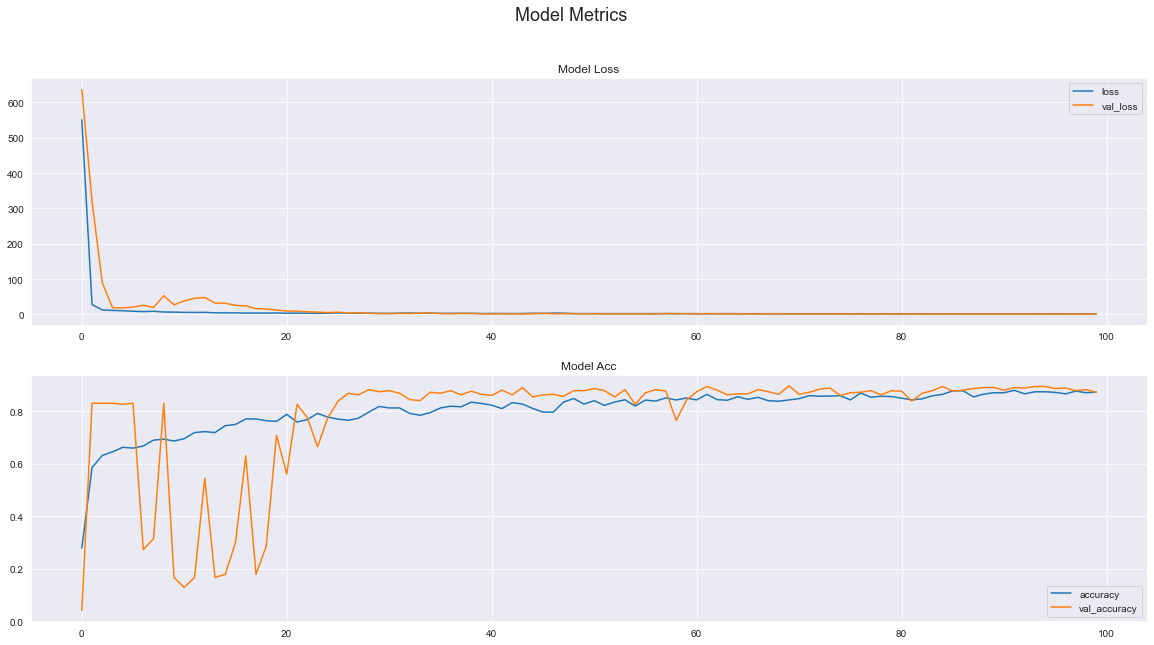

In [39]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_resnet_noNA_C1D4.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

Accuracy and Loss decreased slightly with the addition of the two dense layers.

### Efficient Net (1 Dense Layer)

Using efficientnet as our base pre-trained model, we hope that we can improve our accuracy and loss while not drastically increasing our number of parameters. The below figure shows the different pre-trained models, including efficientnet variants as well as Resnet50, and compares accuracies and parameters

! [Comparing Resnet and Effnet Models](photos/resnet_effnet.png)

In [40]:
# #Build effnet model
# model_effnetB7_noNA_D1 = Sequential() 
# pretrained_model = EfficientNetB7(input_shape= (96, 96, 3), include_top= False, weights='imagenet')
# pretrained_model.trainable = True

# #Build Model Architecture
# model_effnetB7_noNA_D1.add(Conv2D(3, kernel_size=(1, 1), activation='relu', padding= 'same' ,input_shape=(96, 96, 1)))
# model_effnetB7_noNA_D1.add(LeakyReLU(alpha=0.1))
# model_effnetB7_noNA_D1.add(pretrained_model)
# model_effnetB7_noNA_D1.add(MaxPooling2D(pool_size=(2, 2)))
# model_effnetB7_noNA_D1.add(Dropout(0.1))
# model_effnetB7_noNA_D1.add(Flatten())
# model_effnetB7_noNA_D1.add(Dense(30))


# model_effnetB7_noNA_D1.summary()

# model_effnetB7_noNA_D1.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [41]:
# #Train Model
# start_time_effnetB7_noNA_D1 = time.time()
# history_effnetB7_noNA_D1 = model_effnetB7_noNA_D1.fit(train_data_noNA, train_labels_noNA, batch_size=64, epochs=100, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
# train_time_effnetB7_noNA_D1 = time.time() - start_time_effnetB7_noNA_D1

# #pickle
# pickle_stuff(model_effnetB7_noNA_D1, train_time_effnetB7_noNA_D1, history_effnetB7_noNA_D1, 'model_effnetB7_noNA_D1')

#unpickle
model_effnetB7_noNA_D1, train_time_effnetB7_noNA_D1, history_effnetB7_noNA_D1 = unpickle_stuff('model_effnetB7_noNA_D1')

score_effnetB7_noNA_D1 = model_effnetB7_noNA_D1.evaluate(dev_data, dev_labels)
print('Test score:', score_effnetB7_noNA_D1[0]) 
print('Test accuracy:', score_effnetB7_noNA_D1[1])

16/16 [==============================] - 7s 236ms/step - loss: 1.0642 - accuracy: 0.9120
Test score: 1.0641710758209229
Test accuracy: 0.9120000600814819


Text(0.5, 0.98, 'Model Metrics')

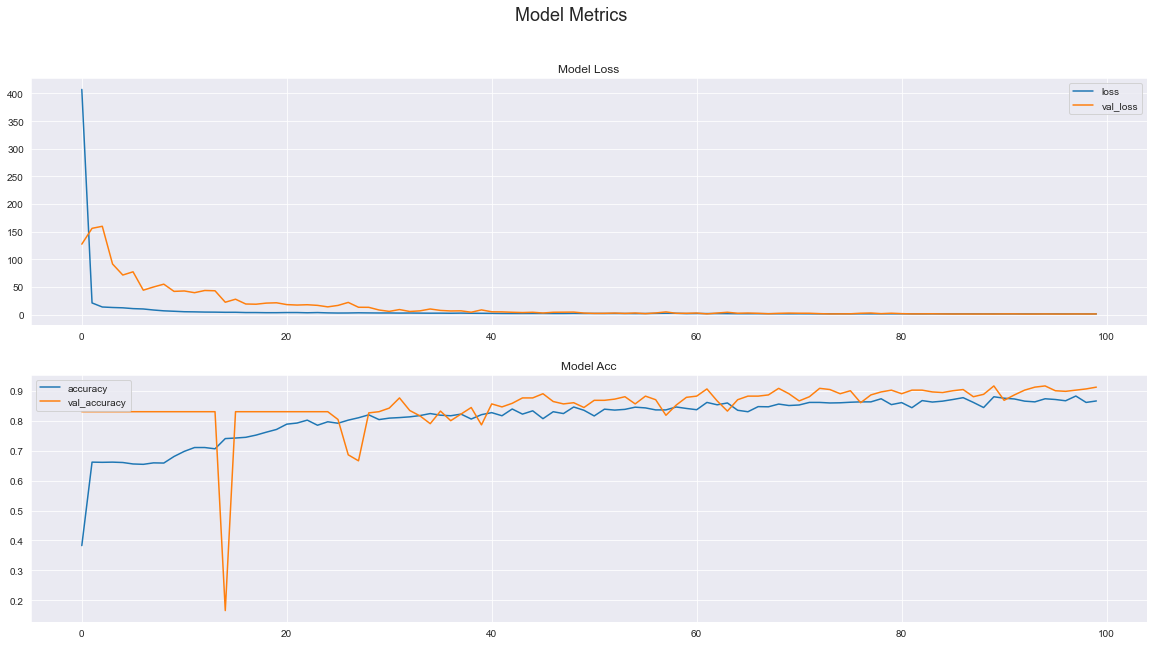

In [42]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_effnetB7_noNA_D1.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

### EfficientNet_v2B3 try number 2 (two conv, two dense, using Efficientnetv2_B3)
Attempting to hit a similar accuracy as the previous model, but with less parameters using the Efficientnet B3 model instead of the larger B7 model. 


In [43]:
# #Build effnet model
# model_effnetV2B3_noNA_C2D2 = Sequential() 
# pretrained_model = EfficientNetV2B3(input_shape= (96, 96, 3), include_top= False, weights='imagenet')
# pretrained_model.trainable = True

# #Build Model Architecture
# model_effnetV2B3_noNA_C2D2.add(Conv2D(24, kernel_size=(2, 2), activation='relu', padding= 'same' ,input_shape=(96, 96, 1)))
# model_effnetV2B3_noNA_C2D2.add(LeakyReLU(alpha=0.2))
# model_effnetV2B3_noNA_C2D2.add(Conv2D(3, kernel_size=(1, 1), activation='relu', padding= 'same' ,input_shape=(96, 96, 24)))
# model_effnetV2B3_noNA_C2D2.add(LeakyReLU(alpha=0.1))
# model_effnetV2B3_noNA_C2D2.add(pretrained_model)
# model_effnetV2B3_noNA_C2D2.add(MaxPooling2D(pool_size=(2, 2)))
# model_effnetV2B3_noNA_C2D2.add(Dropout(0.1))
# model_effnetV2B3_noNA_C2D2.add(Flatten())
# model_effnetV2B3_noNA_C2D2.add(Dense(90))
# model_effnetV2B3_noNA_C2D2.add(Dense(30))


# model_effnetV2B3_noNA_C2D2.summary()

# model_effnetV2B3_noNA_C2D2.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [44]:
# #Train Model
# start_time_effnetV2B3_noNA_C2D2 = time.time()
# history_effnetV2B3_noNA_C2D2 = model_effnetV2B3_noNA_C2D2.fit(train_data_noNA, train_labels_noNA, batch_size=64, epochs=100, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
# train_time_effnetV2B3_noNA_C2D2 = time.time() - start_time_effnetV2B3_noNA_C2D2

# #pickle
# pickle_stuff(model_effnetV2B3_noNA_C2D2, train_time_effnetV2B3_noNA_C2D2, history_effnetV2B3_noNA_C2D2, 'model_effnetV2B3_noNA_C2D2')

#unpickle
model_effnetV2B3_noNA_C2D2, train_time_effnetV2B3_noNA_C2D2, history_effnetV2B3_noNA_C2D2 = unpickle_stuff('model_effnetV2B3_noNA_C2D2')

#Evaluate Model
score_effnetV2B3_noNA_C2D2 = model_effnetV2B3_noNA_C2D2.evaluate(dev_data, dev_labels)
print('Test score:', score_effnetV2B3_noNA_C2D2[0]) 
print('Test accuracy:', score_effnetV2B3_noNA_C2D2[1])

16/16 [==============================] - 4s 123ms/step - loss: 1.2761 - accuracy: 0.8700
Test score: 1.2760850191116333
Test accuracy: 0.8700000643730164


Text(0.5, 0.98, 'Model Metrics')

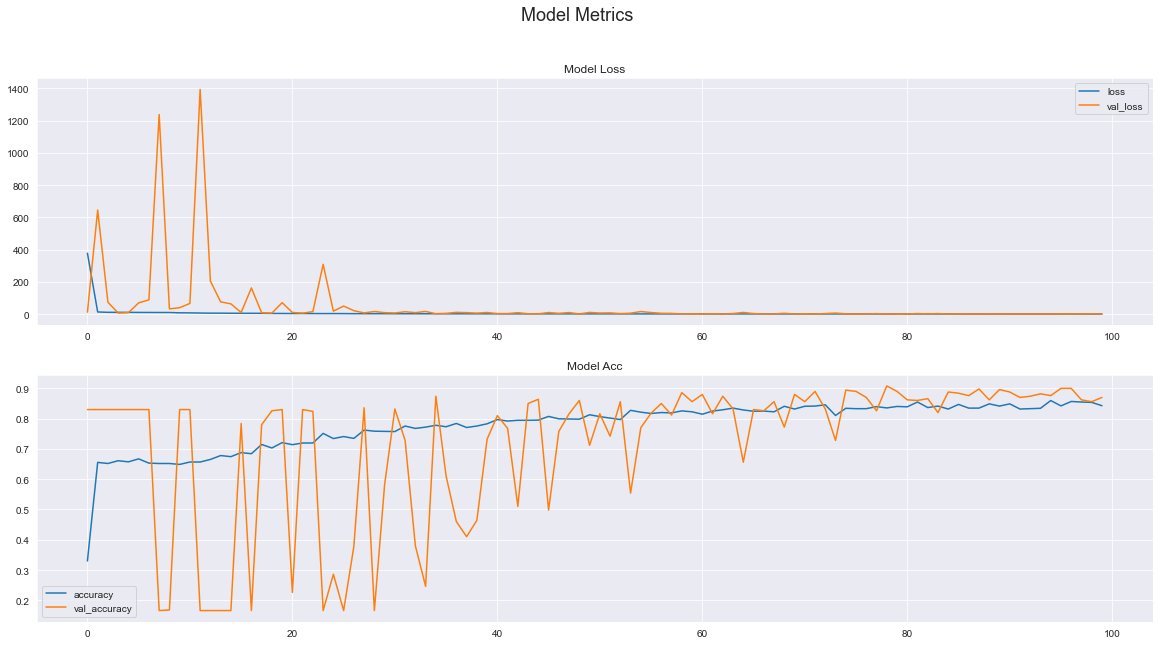

In [45]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_effnetV2B3_noNA_C2D2.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

### Resnet50 with Augmented Data - Transfer Learning
Seeing the high accuracy and low loss of the transfer learning models of Resnet50 and Efficientnet B7, we will use one of each of these models and run our augmented data through the model to try and improve the accuracy as well as increase the generalization of our model.

In [46]:
# #Build Resnet model
# model_resnet_aug_D2 = Sequential() 
# pretrained_model = ResNet50V2(input_shape=(96,96,3), include_top=False, weights='imagenet')
# pretrained_model.trainable = True

# #Build Model Architecture
# model_resnet_aug_D2.add(Conv2D(3, kernel_size=(1, 1), activation='relu', padding= 'same',  input_shape=(96, 96, 1)))
# model_resnet_aug_D2.add(LeakyReLU(alpha=0.1))
# model_resnet_aug_D2.add(pretrained_model)
# model_resnet_aug_D2.add(MaxPooling2D(pool_size=(2, 2)))
# model_resnet_aug_D2.add(Dropout(0.1))
# model_resnet_aug_D2.add(Flatten())
# model_resnet_aug_D2.add(Dense(96))
# model_resnet_aug_D2.add(Dense(30))


# model_resnet_aug_D2.summary()
# model_resnet_aug_D2.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [47]:
# #Train Model
# start_time_resnet_aug_D2 = time.time()
# history_resnet_aug_D2 = model_resnet_aug_D2.fit(train_data_aug, train_labels_aug, batch_size=64, epochs=100, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
# train_time_resnet_aug_D2 = time.time() - start_time_resnet_aug_D2

# #pickle
# pickle_stuff(model_resnet_aug_D2, train_time_resnet_aug_D2, history_resnet_aug_D2, 'model_resnet_aug_D2')

#unpickle
model_resnet_aug_D2, train_time_resnet_aug_D2, history_resnet_aug_D2 = unpickle_stuff('model_resnet_aug_D2')


score_resnet_aug_D2 = model_resnet_aug_D2.evaluate(dev_data, dev_labels)
print('Test score:', score_resnet_aug_D2[0]) 
print('Test accuracy:', score_resnet_aug_D2[1])

16/16 [==============================] - 2s 52ms/step - loss: 0.6266 - accuracy: 0.9260
Test score: 0.6266014575958252
Test accuracy: 0.9260000586509705


Text(0.5, 0.98, 'Model Metrics')

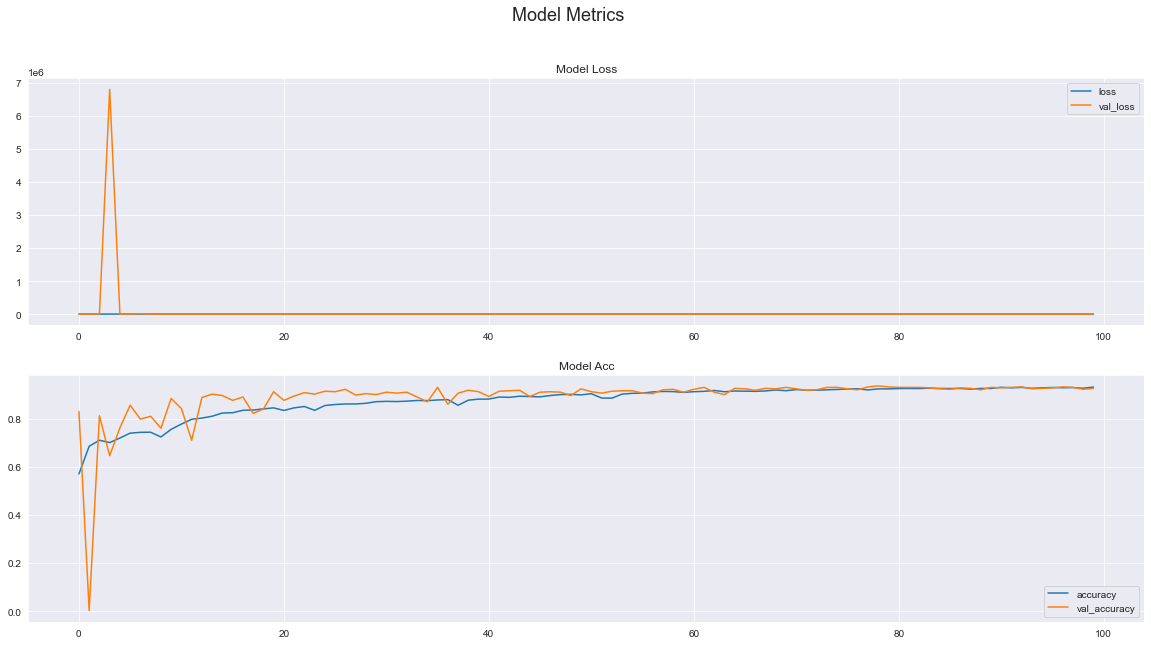

In [48]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_resnet_aug_D2.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

Really happy with the accuracy and the low loss in this model - the best we havce seen so far.

### Efficientnet B7 with Augmented data 
With the success of the Resnet transfer learning model and the augmented data, we expect the efficientnet B7 model to have even better metrics, albeit with more parameters.

In [49]:
# #Build Effnet model
# model_effnetB7_aug_D1 = Sequential() 
# pretrained_model = EfficientNetB7(input_shape= (96, 96, 3), include_top= False, weights='imagenet')
# pretrained_model.trainable = True

# #Build Model Architecture
# model_effnetB7_aug_D1.add(Conv2D(3, kernel_size=(2, 2), activation='relu', padding= 'same' ,input_shape=(96, 96, 1)))
# model_effnetB7_aug_D1.add(LeakyReLU(alpha=0.1))
# model_effnetB7_aug_D1.add(pretrained_model)
# model_effnetB7_aug_D1.add(MaxPooling2D(pool_size=(2, 2)))
# model_effnetB7_aug_D1.add(Dropout(0.1))
# model_effnetB7_aug_D1.add(Flatten())
# model_effnetB7_aug_D1.add(Dense(30))


# model_effnetB7_aug_D1.summary()

# model_effnetB7_aug_D1.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])


In [50]:
# #Train Model
# start_time_effnetB7_aug_D1 = time.time()
# history_effnetB7_aug_D1 = model_effnetB7_aug_D1.fit(train_data_aug, train_labels_aug, batch_size=64, epochs=80, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
# train_time_effnetB7_aug_D1 = time.time() - start_time_effnetB7_aug_D1


# #Evaluate Model
# score_effnetB7_aug_D1 = model_effnetB7_aug_D1.evaluate(dev_data, dev_labels)
# print('Test score:', score_effnetB7_aug_D1[0])
# print('Test accuracy:', score_effnetB7_aug_D1[1])

In [51]:
# #finetune
# pretrained_model.trainable = True
# model_effnetB7_aug_D1.summary()

# model_effnetB7_aug_D1.compile(
#     optimizer=Adam(1e-5),
#     loss='mean_squared_error',
#     metrics=['accuracy']
# )

# start2_time_effnetB7_aug_D1 = time.time()
# history_effnetB7_aug_D1 = model_effnetB7_aug_D1.fit(train_data_aug, train_labels_aug, batch_size=64, epochs=20, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
# train_time_effnetB7_aug_D1 = (time.time() - start2_time_effnetB7_aug_D1) + train_time_effnetB7_aug_D1

# #pickle
# pickle_stuff(model_effnetB7_aug_D1, train_time_effnetB7_aug_D1, history_effnetB7_aug_D1, 'model_effnetB7_aug_D1')

#unpickle
model_effnetB7_aug_D1, train_time_effnetB7_aug_D1, history_effnetB7_aug_D1 = unpickle_stuff('model_effnetB7_aug_D1')

#Evaulate Model
score_effnetB7_aug_D1 = model_effnetB7_aug_D1.evaluate(dev_data, dev_labels)
print('Test score:', score_effnetB7_aug_D1[0]) 
print('Test accuracy:', score_effnetB7_aug_D1[1])

16/16 [==============================] - 8s 264ms/step - loss: 0.6004 - accuracy: 0.9500
Test score: 0.6003601551055908
Test accuracy: 0.9500000476837158


Text(0.5, 0.98, 'Model Metrics')

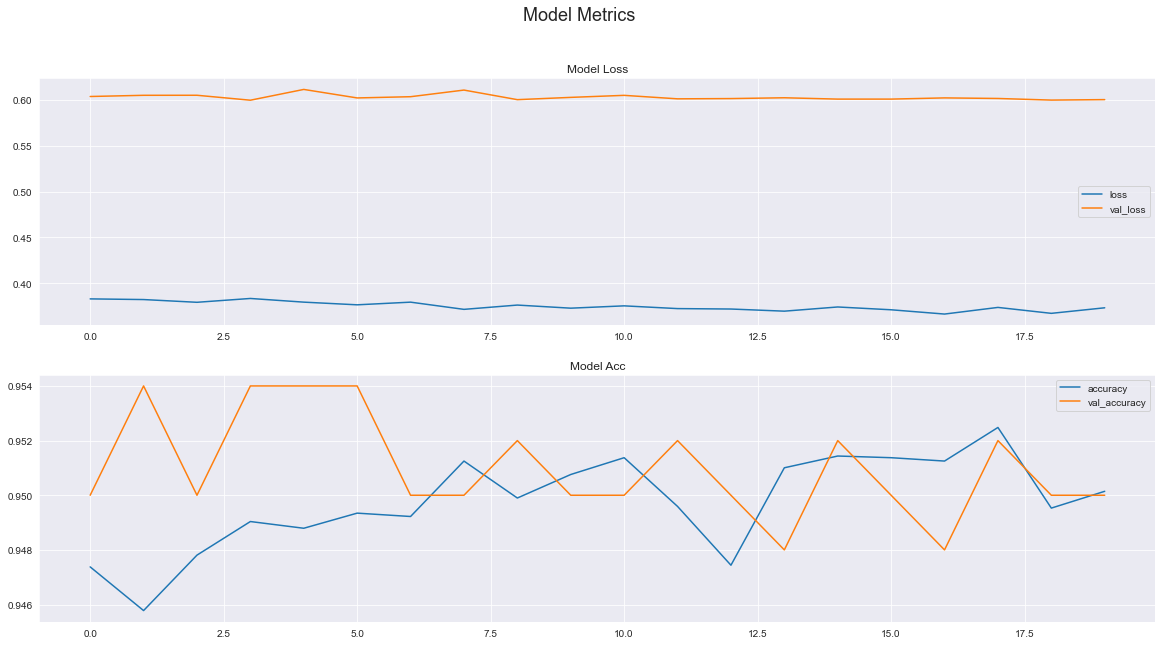

In [52]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_effnetB7_aug_D1.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

Our assumption was correct. This last model shows the lowest loss and the highest accuracy of all the models. This will equate to the best score in the kaggle competition, which evaluates soley on the mean squared error (loss). However, in certain scenarios we may have a different sense of "goodness" than the mean squared error.

## Evaluating the Models

In [117]:
scores = pd.DataFrame({
    "Baseline w/ Missing Values": 0.0,
    "Baseline w/o Missing Values": .8299,
    "CNN w/ FFill": .166,
    "CNN w/o Missing Values": .8280,
    "Resnet50 Pre-trained w/ 1 Dense Layer": .89,
    "Resnet Pre-trained w/ 2 Dense Layers": .90,
    "Resnet Pre-trained w/ Many Dense Layers": .8720,
    "EfficientNet w/ 1 Dense Layer": .912,
    "EfficientNetv2B3 w/ 2 Conv, 2 Dense layers": .8700,
    "Resnet50 w/ Augmented Data": .9260,
    "EfficientNet w/ Augmented Data": .9480,
    "EfficientNet w/ Augmented Data (Finetuned)": .9500
}, index = [0]).T.rename(columns = {0: "Score"})

/var/folders/6j/jm18hzns1bb3pbzq_6yw69280000gn/T/ipykernel_42556/2582957987.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(scores.index, rotation = 30, ha="right", fontsize = 15)
/var/folders/6j/jm18hzns1bb3pbzq_6yw69280000gn/T/ipykernel_42556/2582957987.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, "0%", "20%", "40%", "60%", "80%", "100%"], fontsize = 15)


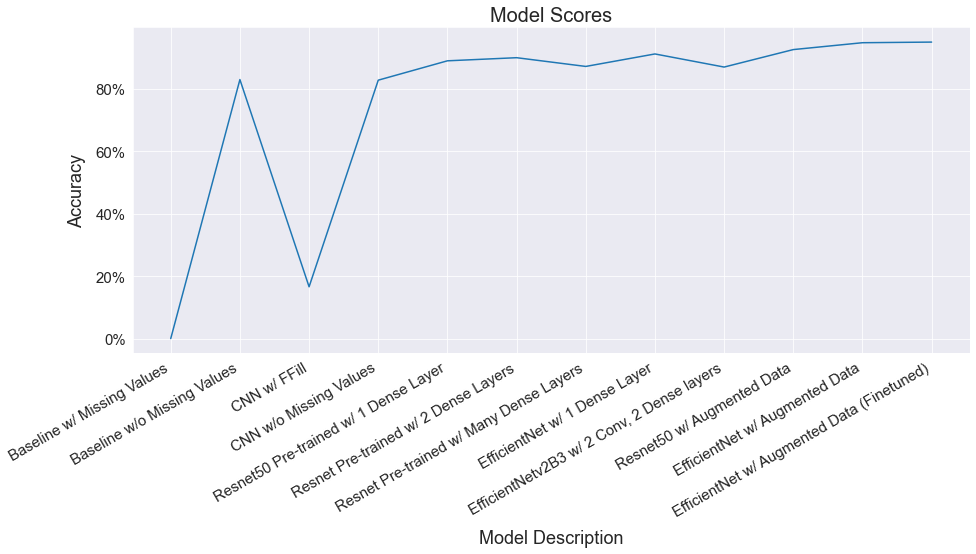

In [118]:
fig, ax = plt.subplots(figsize = (15,6))
sns.lineplot(x = scores.index, y = scores['Score'], ax = ax)
ax.set_title("Model Scores", fontsize = 20)
ax.set_ylabel("Accuracy", fontsize = 18, labelpad = 10)
ax.set_xlabel("Model Description", fontsize = 18, labelpad = 10)
ax.set_xticklabels(scores.index, rotation = 30, ha="right", fontsize = 15)
ax.set_yticklabels([0, "0%", "20%", "40%", "60%", "80%", "100%"], fontsize = 15)
fig.savefig("model_scores.jpg", bbox_inches = "tight", transparent = False)
plt.show()

The above figure wonderfully shows our progression throughout this project. We started with a simple two layer model using all the data, null values included, and worked out way up to a large efficientnet model which gabe us a 95% validation accuracy. The figure also shows how it may be simple to get the accuracy of your model to a decent level, but improving from there is quite challenging.

In [119]:
#Creating eval df
model_names = ['CNN_ffill1', 'CNN_noNA1', 'effnetV2B3_noNA_C2D2', 'effnetB7_noNA_D1', 'effnetB7_aug_D1', 'resnet_noNA_C1D4', 'resnet_aug_D2']
model_list = [model_CNN_ffill1, model_CNN_noNA1, model_effnetV2B3_noNA_C2D2, model_effnetB7_noNA_D1, model_effnetB7_aug_D1, model_resnet_noNA_C1D4, model_resnet_aug_D2]
param_count = [model.count_params() for model in model_list]
acc_scores = [score_CNN_ffill1[1], score_CNN_noNA1[1], score_effnetV2B3_noNA_C2D2[1], score_effnetB7_noNA_D1[1], score_effnetB7_aug_D1[1], score_resnet_noNA_C1D4[1], score_resnet_aug_D2[1]]
loss_scores = [score_CNN_ffill1[0], score_CNN_noNA1[0], score_effnetV2B3_noNA_C2D2[0], score_effnetB7_noNA_D1[0], score_effnetB7_aug_D1[0], score_resnet_noNA_C1D4[0], score_resnet_aug_D2[0]]
train_time = [train_time_CNN_ffill1, train_time_CNN_noNA1, train_time_effnetV2B3_noNA_C2D2, train_time_effnetB7_noNA_D1, train_time_effnetB7_aug_D1, train_time_resnet_noNA_C1D4, train_time_resnet_aug_D2]

eval_df = pd.DataFrame()
eval_df['Model'] = model_names
eval_df['Params'] = param_count
eval_df['Accuracy'] = acc_scores
eval_df['Loss'] = loss_scores
eval_df['Train Time'] = train_time

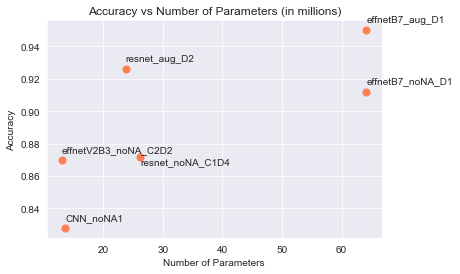

In [122]:
#plot the accuracy vs parameters
eval_df[1:].plot(x= 'Params', y='Accuracy', kind='scatter', c='coral', s=50)

plt.xlabel("Number of Parameters")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Parameters (in millions)")
scale_x = 1e6
ticks_x = FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
plt.gca().xaxis.set_major_formatter(ticks_x)
for i, label in enumerate(eval_df['Model']):
    if label == 'resnet_noNA_C1D4':
        plt.annotate(label, ((eval_df['Params'][i]), (eval_df['Accuracy'][i]- 0.005)), transform = plt.gca().transAxes)
    else:
        plt.annotate(label, ((eval_df['Params'][i]), (eval_df['Accuracy'][i]+ 0.005)), transform = plt.gca().transAxes)
plt.show()

The above figure compares some of our key models and their performance. As discussed prior, accuracy and loss are important metrics, but the number of parameters, and the time to train the model are also important. In certain production scenarios, it may be best to use the resnet augmented data model as it achieves a similar accuracy as the effnet augmented model, but with less than half the number of parameters.

## Creating Submission
formatting the data for submission to kaggle competition

In [ ]:
id_lookup = pd.read_csv('IdLookupTable.csv')

ImageId = list(id_lookup['ImageId']-1)
RowId = list(id_lookup['RowId'])
FeatureName = list(id_lookup['FeatureName'])
feature_list = []
for feature in FeatureName:
    feature_list.append(FeatureName.index(feature))



In [ ]:
def submit(model, test_data, model_name):
    #RowId,ImageId,FeatureName,Location
    #Make Predictions 
    y_pred = model.predict(test_data)

    predictions = []
    for x,y in zip(ImageId, feature_list):
        predictions.append(y_pred[x][y])
        
    row_ids = pd.Series(RowId, name = 'RowId')
    locations = pd.Series(predictions, name = 'Location')
    
    #post processing step 
    locations = locations.clip(0.0,96.0)
    submission_result = pd.concat([row_ids,locations],axis = 1)
    submission_result.to_csv('eff_net_2', index = False)
